In [2]:
# ============================================
# Imports
# ============================================
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from transformers import BertTokenizer, BertForSequenceClassification
from datasets import load_dataset

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
# ============================================
# Device
# ============================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE


device(type='cuda')

In [4]:
# ============================================
# Load SST-5 dataset
# ============================================
dataset = load_dataset("SetFit/sst5")
dataset


Repo card metadata block was not found. Setting CardData to empty.


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 8544
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 1101
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2210
    })
})

In [5]:
# ============================================
# Tokenize
# ============================================
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

dataset_tok = dataset.map(tokenize, batched=True)

# rename and format
dataset_tok = dataset_tok.rename_column("label", "labels")
dataset_tok.set_format(type="torch",
                       columns=["input_ids","attention_mask","labels"])


In [6]:
# ============================================
# DataLoaders
# ============================================
train_loader = DataLoader(dataset_tok["train"], batch_size=16, shuffle=True)
val_loader   = DataLoader(dataset_tok["validation"], batch_size=16)
test_loader  = DataLoader(dataset_tok["test"], batch_size=16)


In [7]:
# ============================================
# Load BERT model — Freeze encoder
# ============================================
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=5
).to(DEVICE)

# Freeze entire BERT encoder
for param in model.bert.parameters():
    param.requires_grad = False

# Ensure classifier head is trainable
for param in model.classifier.parameters():
    param.requires_grad = True

model


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [8]:
# ============================================
# Optimizer + loss
# Only train classifier head
# ============================================
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=2e-4)
criterion = nn.CrossEntropyLoss()


In [9]:
# ============================================
# Training function (one epoch)
# ============================================
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in loader:
        optimizer.zero_grad()

        outputs = model(
            input_ids=batch["input_ids"].to(device),
            attention_mask=batch["attention_mask"].to(device),
            labels=batch["labels"].to(device)
        )

        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(1)
        correct += (preds == batch["labels"].to(device)).sum().item()
        total += batch["labels"].size(0)

    return total_loss / len(loader), correct / total


In [10]:
# ============================================
# Validation function
# ============================================
def evaluate(model, loader, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for batch in loader:
            outputs = model(
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device),
                labels=batch["labels"].to(device)
            )
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = logits.argmax(1)
            correct += (preds == batch["labels"].to(device)).sum().item()
            total += batch["labels"].size(0)

    return total_loss / len(loader), correct / total


In [11]:
# ============================================
# Train 3–5 epochs (baseline BERT)
# ============================================
EPOCHS = 5

for epoch in range(1, EPOCHS+1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, DEVICE)
    val_loss, val_acc = evaluate(model, val_loader, DEVICE)

    print(f"Epoch {epoch}: Train Acc={train_acc:.4f} | Val Acc={val_acc:.4f}")


Epoch 1: Train Acc=0.2904 | Val Acc=0.2752
Epoch 2: Train Acc=0.3165 | Val Acc=0.3179
Epoch 3: Train Acc=0.3350 | Val Acc=0.3388
Epoch 4: Train Acc=0.3471 | Val Acc=0.2970
Epoch 5: Train Acc=0.3511 | Val Acc=0.3624


In [12]:
# ============================================
# Test performance
# ============================================
def test(model, loader, device):
    model.eval()
    preds, labels_list = [], []

    with torch.no_grad():
        for batch in loader:
            logits = model(
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device)
            ).logits

            preds.extend(logits.argmax(1).cpu().tolist())
            labels_list.extend(batch["labels"].cpu().tolist())

    return np.array(preds), np.array(labels_list)

preds, labels = test(model, test_loader, DEVICE)
acc = accuracy_score(labels, preds)

print("Test Accuracy:", acc)
print(classification_report(labels, preds, digits=4))


Test Accuracy: 0.3719457013574661
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       279
           1     0.4083    0.7030    0.5165       633
           2     0.8000    0.0103    0.0203       389
           3     0.3327    0.7196    0.4551       510
           4     0.5000    0.0150    0.0292       399

    accuracy                         0.3719      2210
   macro avg     0.4082    0.2896    0.2042      2210
weighted avg     0.4248    0.3719    0.2618      2210



d:\Programmering\Anaconda\envs\iml\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Programmering\Anaconda\envs\iml\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Programmering\Anaconda\envs\iml\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

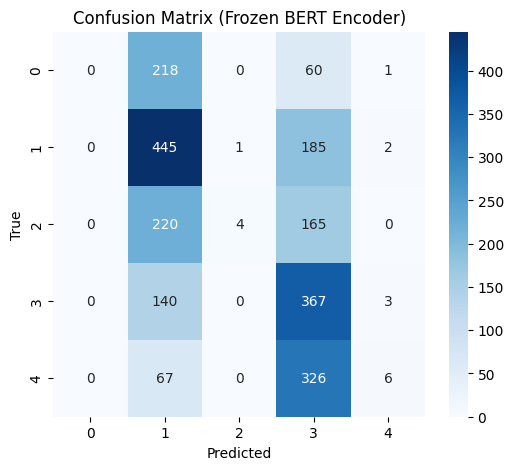

In [13]:
# ============================================
# Confusion matrix
# ============================================
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Frozen BERT Encoder)")
plt.show()
